In [2]:
import numpy as np
from astropy.time import Time

In [3]:
def get_orbital_parameters():
    Re = 6371.0  # Radio de la Tierra en km
    GM = 398600.4405  # Constante gravitacional por masa de la Tierra [km^3/s^2]
    a = 1.30262 * Re  # Semieje mayor en km
    e = 0.16561  # Excentricidad
    omega_deg = 15.0  # Argumento del pericentro en grados
    omega_rad = np.radians(omega_deg)  # en radianes
    tp = Time('2025-03-31 00:00:00', scale='utc')  # Tiempo de paso por el pericentro
    return GM, a, e, omega_rad, tp

GM, a, e, omega, tp = get_orbital_parameters()

print(f"GM = {GM} km³/s²")
print(f"a = {a:.5f} km")
print(f"e = {e}")
print(f"ω = {np.degrees(omega)}°")
print(f"t_p = {tp.iso}")


GM = 398600.4405 km³/s²
a = 8298.99202 km
e = 0.16561
ω = 14.999999999999998°
t_p = 2025-03-31 00:00:00.000


In [4]:
# --- Anomalía media ---
def mean_anomaly(t_obs, GM, a, tp):
    n = np.sqrt(GM / a**3)
    delta_t = (t_obs - tp).sec
    l = n * delta_t
    return l % (2 * np.pi)

# --- Newton-Raphson con precisión de máquina ---
def solve_kepler_newton_preciso(l, e, tol=None, max_iter=100):
    if tol is None:
        tol = 10 * np.finfo(float).eps  # ≈ 2.22e-15
    E = l
    for _ in range(max_iter):
        f = E - e * np.sin(E) - l
        df = 1 - e * np.cos(E)
        E_new = E - f / df
        if abs(E_new - E) < tol:
            return E_new
        E = E_new
    raise RuntimeError("No converge con la tolerancia especificada.")

# --- De E a f ---
def eccentric_to_true_anomaly(E, e):
    f = 2 * np.arctan(np.sqrt((1 + e)/(1 - e)) * np.tan(E / 2))
    return f % (2 * np.pi)

def position(t):
    GM, a, e, omega, tp = get_orbital_parameters()
    l = mean_anomaly(t, GM, a, tp)
    E = solve_kepler_newton_preciso(l, e)
    f = eccentric_to_true_anomaly(E, e)
    r = a * (1 - e**2) / (1 + e * np.cos(f))
    phi = (f + omega) % (2 * np.pi)
    return r, phi

# --- Ejemplo de uso ---
t_test = Time('2025-04-01 00:00:00', scale='utc')
r, phi = position(t_test)

print(f"r  = {r:.15f} km")
print(f"phi = {np.degrees(phi):.15f} grados")


r  = 9667.786055561424291 km
phi = 190.620808644065818 grados


In [5]:
import matplotlib.pyplot as plt

def orbit(num_points=500):
    """
    Grafica la órbita del satélite y la Tierra como un círculo azul.
    
    Parámetros:
        num_points : número de puntos usados para construir la curva
    """
    # Obtener parámetros orbitales
    _, a, e, omega, _ = get_orbital_parameters()
    Re = 6371.0  # Radio de la Tierra [km]

    # Valores de f (anomalía verdadera)
    f_vals = np.linspace(0, 2 * np.pi, num_points)
    
    # r(f)
    r_vals = a * (1 - e**2) / (1 + e * np.cos(f_vals))
    
    # phi = f + omega
    phi_vals = (f_vals + omega) % (2 * np.pi)

    # Crear figura polar
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)

    # Dibujar la órbita
    ax.plot(phi_vals, r_vals, label='Órbita', color='blue')

    # Dibujar la Tierra como círculo
    theta = np.linspace(0, 2*np.pi, 500)
    r_tierra = np.full_like(theta, Re)
    ax.fill(theta, r_tierra, color='skyblue', label='Tierra', alpha=0.6)

    # Marcar el pericentro
    r_peri = a * (1 - e)
    ax.plot([omega], [r_peri], 'ro', label='Pericentro')

    ax.set_title("Órbita del satélite", va='bottom')
    ax.legend(loc='upper right')
    plt.show()


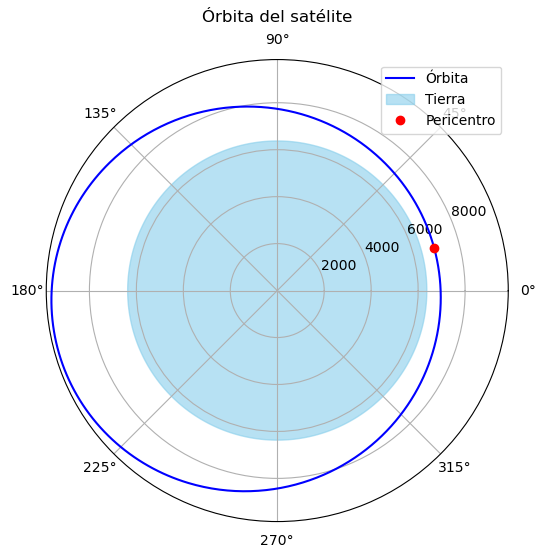

In [6]:
orbit()


In [7]:
from astropy import units as u

def date(r0):
    """
    Calcula el primer instante t posterior al pericentro en el que el satélite
    se encuentra a una distancia radial r0.
    
    Parámetro:
        r0 : distancia deseada [km]
        
    Retorna:
        t : instante (astropy.time.Time)
    """
    GM, a, e, _, tp = get_orbital_parameters()
    n = np.sqrt(GM / a**3)
    
    # Función de r(f) - r0
    def r_diff(f):
        return a * (1 - e**2) / (1 + e * np.cos(f)) - r0
    
    # Búsqueda por bisección en f ∈ [0, 2π]
    f_low = 0
    f_high = 2 * np.pi
    tol = 1e-14
    for _ in range(100):
        f_mid = (f_low + f_high) / 2
        if abs(r_diff(f_mid)) < tol:
            break
        if r_diff(f_low) * r_diff(f_mid) < 0:
            f_high = f_mid
        else:
            f_low = f_mid

    f = f_mid % (2 * np.pi)

    # Convertir f → E
    E = 2 * np.arctan(np.sqrt((1 - e)/(1 + e)) * np.tan(f / 2))
    E = E % (2 * np.pi)

    # Anomalía media
    l = E - e * np.sin(E)

    # Tiempo desde el pericentro
    delta_t = l / n  # en segundos
    t = tp + delta_t * u.s
    return t


In [8]:
r0 = 1.5 * 6371.0  # km
t_encontrado = date(r0)
print(f"Fecha en que el satélite está a {r0} km: {t_encontrado.iso}")


Fecha en que el satélite está a 9556.5 km: 2025-03-31 00:53:04.530
